The chatbot cannot remember past interactions on its own,  
which limits its ability to have coherent,  
multi-turn conversations. you will add memory to address this

If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()  # Load from .env file

api_key = os.getenv("TAVILY_API_KEY")

print("API key loaded:", api_key[:4] + "..." if api_key else "Not found")

API key loaded: tvly...


In [2]:
from langchain.chat_models import init_chat_model # type: ignore

# Follow the steps here to configure your credentials:
# https://docs.aws.amazon.com/bedrock/latest/userguide/getting-started.html

llm = init_chat_model(
    "anthropic.claude-3-haiku-20240307-v1:0",
    model_provider="bedrock_converse",
)

In [4]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

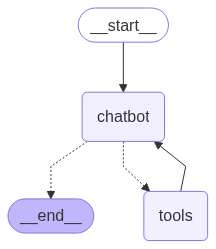

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
user_input = "Hi there! My name is Will."

config = {"configurable": {"thread_id": "1"}}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

It's nice to meet you, Will! I'm an AI assistant created by Anthropic. I'm here to help with any questions or tasks you may have. Please feel free to ask me about anything, and I'll do my best to provide helpful information or assistance.


In [7]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will. It's nice to meet you!


In [8]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I'm afraid I don't actually remember your name, as I don't have a persistent memory of our previous interactions. I'm Claude, an AI assistant created by Anthropic to be helpful, harmless, and honest. Could you please tell me your name so I can address you properly?


Inspect the state  
What goes into a checkpoint?   
We are using the thread_id: 1

In [9]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='36041002-b030-47d6-8144-ab9f397dfffd'), AIMessage(content="It's nice to meet you, Will! I'm an AI assistant created by Anthropic. I'm here to help with any questions or tasks you may have. Please feel free to ask me about anything, and I'll do my best to provide helpful information or assistance.", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'eef0fda8-8701-4a0f-8fc5-a52561d0cf9d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 22 May 2025 22:39:20 GMT', 'content-type': 'application/json', 'content-length': '423', 'connection': 'keep-alive', 'x-amzn-requestid': 'eef0fda8-8701-4a0f-8fc5-a52561d0cf9d'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [947]}, 'model_name': 'anthropic.claude-3-haiku-20240307-v1:0'}, id='run--66ab5dbe-bc0d-4415-943d-8dc1d581a74f-0', usage_metadata={'input_tokens': 13

The snapshot above contains the current state values, corresponding config, and the next node to process. In our case, the graph has reached an END state, so next is empty.